## 4. Finetuning YOLOv11 on compound separation

Install the dependencies
!pip install ultralytics wandb weave opencv-python requests pillow


In [ ]:
import json
import os
import requests
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

```
# create a data.yaml file with the following structure:

train: /content/dataset/images/train
val: /content/dataset/images/val
nc: 8
names: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
```

In [ ]:
# This the json file with the labelled images from MLTurk described in the paper: https://arxiv.org/abs/2101.09903
json_file_path = "/content/export-2024-07-11T05_19_22.318Z.json"
with open(json_file_path, 'r') as f:
    data = json.load(f)

In [ ]:
def polygon_to_bbox(polygon):
    x_coords = [point['x'] for point in polygon]
    y_coords = [point['y'] for point in polygon]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min
    return x_center, y_center, width, height

def is_point_in_polygon(point, polygon):
    x, y = point
    inside = False
    n = len(polygon)
    p1x, p1y = polygon[0]['x'], polygon[0]['y']
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]['x'], polygon[i % n]['y']
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

# Function to create class ID mapping with priority for specific labels
def create_class_id_mapping(subfigure_labels, priority_labels):
    standard_labels = {
        'a': 0, 'A': 0, 'a.': 0, 'A.': 0,
        'b': 1, 'B': 1, 'b.': 1, 'B.': 1,
        'c': 2, 'C': 2, 'c.': 2, 'C.': 2, " c":2,
        'd': 3, 'D': 3, 'd.': 3, 'D.': 3,
        'e': 4, 'E': 4, 'e.': 4, 'E.': 4,
        'f': 5, 'F': 5, 'f.': 5, 'F.': 5,
        'g': 6, 'G': 6, 'g.': 6, 'G.': 6,
        'h': 7, 'H': 7, 'h.': 7, 'H.': 7,
        '(a)': 0, '(A)': 0, '(a)': 0, '(A)': 0,
        '(b)': 1, '(B)': 1, '(b)': 1, '(B)': 1,
        '(c)': 2, '(C)': 2, '(c)': 2, '(C)': 2,
        '(d)': 3, '(D)': 3, '(d)': 3, '(D)': 3,
        '(e)': 4, '(E)': 4, '(e)': 4, '(E)': 4,
        '(f)': 5, '(F)': 5, '(f)': 5, '(F)': 5,
        '(g)': 6, '(G)': 6, '(g)': 6, '(G)': 6,
        '(h)': 7, '(H)': 7, '(h)': 7, '(H)': 7,
        'a)': 0, 'A)': 0, 'b)': 1, 'B)': 1,
        'c)': 2, 'C)': 2, 'd)': 3, 'D)': 3,
        'e)': 4, 'E)': 4, 'f)': 5, 'F)': 5,
        'g)': 6, 'G)': 6, 'h)': 7, 'H)': 7
    }

    class_id_mapping = {}
    current_id = 0

    for label in priority_labels:
        if label in subfigure_labels and label not in class_id_mapping:
            class_id_mapping[label] = standard_labels[label]
            current_id += 1

    return class_id_mapping

# Extract all unique subfigure labels
subfigure_labels = set()
for entry in data:
    for subfigure in entry['Label'].get('Subfigure Label', []):
        subfigure_labels.add(subfigure['text'].strip('()'))

priority_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

class_id_mapping = create_class_id_mapping(subfigure_labels, priority_labels)
print("Class ID Mapping:", class_id_mapping)

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=1164, random_state=42)

for split in ['train', 'val']:
    os.makedirs(f'dataset/images/{split}', exist_ok=True)
    os.makedirs(f'dataset/labels/{split}', exist_ok=True)

def process_data_split(data_split, split_name):
    for entry in data_split:
        image_url = entry['Labeled Data']
        image_id = entry['External ID'].split('.')[0]
        image_path = f'dataset/images/{split_name}/{image_id}.png'

        response = requests.get(image_url)
        with open(image_path, 'wb') as img_file:
            img_file.write(response.content)

        image = Image.open(image_path)
        img_width, img_height = image.size

        label_file_path = f'dataset/labels/{split_name}/{image_id}.txt'
        with open(label_file_path, 'w') as label_file:
            for annotation in entry['Label'].get('Master Image', []):
                bbox = polygon_to_bbox(annotation['geometry'])
                x_center, y_center, width, height = bbox
                x_center /= img_width
                y_center /= img_height
                width /= img_width
                height /= img_height

                # Find corresponding subfigure label
                for sub in entry['Label'].get('Subfigure Label', []):
                    if len(sub['geometry']) >= 4:
                        label_center = (
                            (sub['geometry'][0]['x'] + sub['geometry'][2]['x']) / 2,
                            (sub['geometry'][0]['y'] + sub['geometry'][2]['y']) / 2
                        )
                        if is_point_in_polygon(label_center, annotation['geometry']):
                            subfigure_label = sub['text'].strip('()')
                            class_id = class_id_mapping.get(subfigure_label)
                            if class_id is not None:
                                label_file.write(f'{class_id} {x_center} {y_center} {width} {height}\n')
                                print(f'Processed {image_id}: Class ID: {class_id}, BBox: {x_center}, {y_center}, {width}, {height}')
                            break

# Process the data splits
process_data_split(train_data, 'train')
process_data_split(test_data, 'val')

# Save class ID mapping to a file
with open('dataset/labels/class_id_mapping.txt', 'w') as mapping_file:
    for label, class_id in class_id_mapping.items():
        mapping_file.write(f'{label}: {class_id}\n')

print('Conversion complete!')

In [ ]:
# correcting formatting issues with images 

from PIL import Image
import glob

image_paths = glob.glob('/content/dataset/images/train/*.png')

for image_path in image_paths:
    with Image.open(image_path) as img:
        if img.format == 'GIF':
            img.save(image_path, format='PNG')

image_paths = glob.glob('/content/dataset/images/val/*.png')

for image_path in image_paths:
    with Image.open(image_path) as img:
        if img.format == 'GIF':
            img.save(image_path, format='PNG')

In [ ]:
from ultralytics import YOLO
import wandb

# Load a pretrained YOLOv11 model
model = YOLO("yolo11x.pt")
model_path = "yolov11x_finetunedv2.pt"

results = model.train(
    data="./data.yaml",
    epochs=150,
    imgsz=608,
    project="yolo11x_training",  # wandb project name
    name="yolov11x_finetune"     # wandb run name
)

# Save the fine-tuned model
model.save(model_path)
wandb.init("yolo11x_training")
wandb.log_model(model_path)
wandb.finish()

In [ ]:
# Save the fine-tuned model
model.save(model_path)
wandb.init(project="yolo11x_training")


wandb: Currently logged in as: kvriza. Use `wandb login --relogin` to force relogin


Printing the test set results after finetuning YOLOv11x on compound separation

In [ ]:
metrics = model.val(
    data="./data.yaml",
    batch=16,
    imgsz=640,
    conf=0.001,
    iou=0.65,
    save_json=True,
    plots=True
)

Ultralytics 8.3.25 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11x summary (fused): 464 layers, 56,836,264 parameters, 0 gradients, 194.5 GFLOPs


val: Scanning /content/dataset/labels/val.cache... 952 images, 186 backgrounds, 14 corrupt: 100%|██████████| 952/952 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/dataset/images/val/C0CE00988A_fig4.png: 1 duplicate labels removed
val: WARNING ⚠️ /content/dataset/images/val/ncomms10603_fig3.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0015      1.0015      1.0015]
val: WARNING ⚠️ /content/dataset/images/val/ncomms10603_fig7.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0015]
val: WARNING ⚠️ /content/dataset/images/val/ncomms4801_fig2.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0015]
val: WARNING ⚠️ /content/dataset/images/val/ncomms9711_fig6.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0015]
val: WARNING ⚠️ /content/dataset/images/val/nn203661n_fig4.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0034]
val: WARNING ⚠️ /content/dataset/images/val/s41467-017-00332-x_fig3.png: ignoring corrupt image/label: non-normalized 


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:48<00:00,  1.23it/s]


                   all        938       3261      0.904      0.939      0.961       0.94
                     a        730        735      0.915       0.95       0.97      0.955
                     b        725        728      0.876      0.942      0.957      0.945
                     c        603        608      0.909      0.944      0.958      0.938
                     d        489        491      0.908      0.926      0.959      0.942
                     e        279        281      0.905      0.944      0.966      0.952
                     f        231        231       0.91      0.931      0.963      0.941
                     g        108        108      0.909      0.921      0.954      0.926
                     h         79         79      0.904      0.956      0.961      0.921
Speed: 0.2ms preprocess, 47.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Saving yolo11x_training/yolov11x_finetune2/predictions.json...
Results saved to yolo11x_training/yolov11x_finetune2


In [ ]:
# Run inference with adjusted NMS parameters
image_path = "nature04705_fig3.jpg"

results = model.predict(
    source=image_path,
    imgsz=640,
    conf=0.25,
    iou=0.45,
    max_det=100,        
    agnostic_nms=False,
)


image 1/1 /content/nature04705_fig3.jpg: 640x320 1 a, 1 b, 1 c, 62.2ms
Speed: 2.1ms preprocess, 62.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)



image 1/1 /content/nature04705_fig3.jpg: 640x320 1 a, 1 b, 1 c, 57.8ms
Speed: 1.9ms preprocess, 57.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


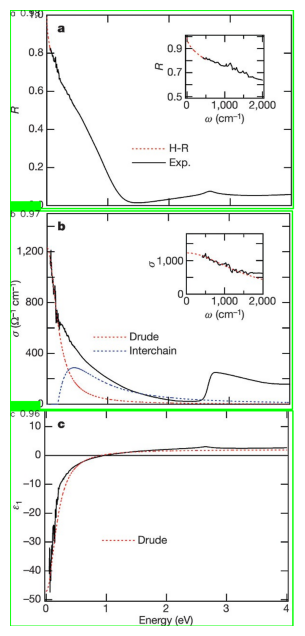

In [ ]:
results = model.predict(
    source=image_path,
    imgsz=640,
    conf=0.25,
    iou=0.45,
    max_det=100,
    agnostic_nms=False, 
)

for result in results:
    detections_per_class = {}
    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = box.conf[0]
        if cls_id not in detections_per_class or conf > detections_per_class[cls_id].conf[0]:
            detections_per_class[cls_id] = box

    final_detections = list(detections_per_class.values())


    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        continue  

    for box in final_detections:
        x1, y1, x2, y2 = box.xyxy[0]
        conf = box.conf[0]
        cls_id = int(box.cls[0])
        class_name = model.names[cls_id]

        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        color = (0, 255, 0) 
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        label = f"{class_name} {conf:.2f}"

        (text_width, text_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1
        )

        text_bg_x1 = x1
        text_bg_y1 = y1 - text_height - baseline
        text_bg_x2 = x1 + text_width
        text_bg_y2 = y1

        cv2.rectangle(
            image,
            (text_bg_x1, text_bg_y1),
            (text_bg_x2, text_bg_y2),
            color,
            -1 
        )

        cv2.putText(
            image,
            label,
            (x1, y1 + 2*baseline),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 0), 
            1,
            cv2.LINE_AA
        )

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


image 1/1 /content/ncomms2152_fig3.jpg: 640x608 1 a, 1 b, 1 c, 1 d, 1 e, 1 f, 1 g, 1 h, 87.9ms
Speed: 2.5ms preprocess, 87.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


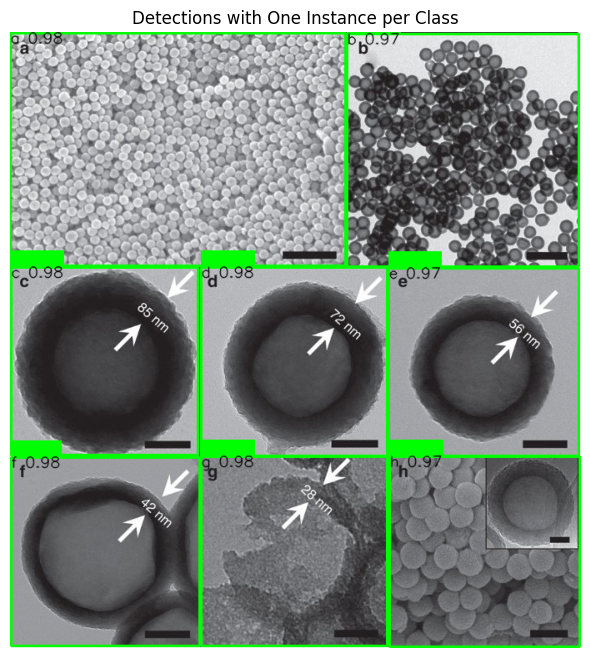

In [ ]:
image_path = "ncomms2152_fig3.jpg"

results = model.predict(
    source=image_path,
    imgsz=640,
    conf=0.25,
    iou=0.45,
    max_det=100,
    agnostic_nms=False,
)

for result in results:
    detections_per_class = {}
    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = box.conf[0]
        if cls_id not in detections_per_class or conf > detections_per_class[cls_id].conf[0]:
            detections_per_class[cls_id] = box

    final_detections = list(detections_per_class.values())

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        continue  # Skip if the image cannot be loaded

    for box in final_detections:
        x1, y1, x2, y2 = box.xyxy[0]
        conf = box.conf[0]
        cls_id = int(box.cls[0])
        class_name = model.names[cls_id]

        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        color = (0, 255, 0)  
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        label = f"{class_name} {conf:.2f}"

        (text_width, text_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1
        )

        text_bg_x1 = x1
        text_bg_y1 = y1 - text_height - baseline
        text_bg_x2 = x1 + text_width
        text_bg_y2 = y1

        cv2.rectangle(
            image,
            (text_bg_x1, text_bg_y1),
            (text_bg_x2, text_bg_y2),
            color,
            -1  
        )

        cv2.putText(
            image,
            label,
            (x1, y1 + 2*baseline),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 0),  
            1,
            cv2.LINE_AA
        )

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Detections with One Instance per Class')
    plt.show()